In [294]:
from google.oauth2 import service_account
from google.cloud import bigquery
import pandas_gbq
import os
import json
import altair as alt
import plotly.express as px
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import numpy as np

In [194]:
sql = "SELECT * FROM `Congress.fact_roll_call_vote` LIMIT 10"
project_id='testproject-420401'
# # Uses st.cache_data to only rerun when the query changes or after 10 min.
# @st.cache_data(ttl=600)
# def run_query(query):
#     query_job = client.query(query)
#     rows_raw = query_job.result()
#     # Convert to list of dicts. Required for st.cache_data to hash the return value.
#     rows = [dict(row) for row in rows_raw]
#     return rows

# rows = run_query("SELECT * FROM `Congress.fact_roll_call_vote` LIMIT 10")


df = pandas_gbq.read_gbq(sql, project_id=project_id)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [195]:
sql = """
SELECT dv.chamber
      ,dv.bill_name
      ,dv.result
      ,db.title
      ,db.policy_area
      ,D_yea_or_aye_votes
      ,R_yea_or_aye_votes
      ,I_yea_or_aye_votes
      ,D_nay_or_no_votes
      ,R_nay_or_no_votes
      ,I_nay_or_no_votes
      ,D_abstain_votes
      ,R_abstain_votes
      ,I_abstain_votes
      ,yea_nay_gap_votes,
      db.most_recent_text
    FROM `Congress.dim_votes` dv
        left join `Congress.dim_bills` db on dv.bill_key = db.bill_key
    WHERE dv.chamber = 'House' AND abs(dv.yea_nay_gap_votes) <=10
order by abs(dv.yea_nay_gap_votes)
"""

In [287]:
sql = """
SELECT dv.chamber
      ,dv.bill_name
      ,dv.result
      ,db.title
      ,db.policy_area
      ,D_yea_or_aye_votes
      ,R_yea_or_aye_votes
      ,I_yea_or_aye_votes
      ,D_nay_or_no_votes
      ,R_nay_or_no_votes
      ,I_nay_or_no_votes
      ,D_abstain_votes
      ,R_abstain_votes
      ,I_abstain_votes
      ,yea_nay_gap_votes
      ,db.most_recent_text
      ,rank() over(order by abs(dv.yea_nay_gap_votes)) closeness_rank
    FROM `Congress.dim_votes` dv
        left join `Congress.dim_bills` db on dv.bill_key = db.bill_key

order by abs(dv.yea_nay_gap_votes)
"""
    # WHERE dv.chamber = 'House' 
# AND abs(dv.yea_nay_gap_votes) <=10

In [288]:
df = pandas_gbq.read_gbq(sql, project_id=project_id)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [289]:
df.result.value_counts()

result
Passed                                        211
Failed                                         58
Joint Resolution Passed                        19
Bill Passed                                    13
Motion Rejected                                10
Cloture Motion Agreed to                       10
Motion Agreed to                                8
Motion to Table Failed                          8
Motion to Proceed Agreed to                     8
Cloture on the Motion to Proceed Rejected       6
Cloture on the Motion to Proceed Agreed to      5
Veto Sustained                                  5
Motion to Table Agreed to                       5
Joint Resolution Defeated                       4
Motion to Discharge Rejected                    3
Resolution Agreed to                            3
Bill Defeated                                   2
Motion to Refer Rejected                        2
Conference Report Agreed to                     1
Name: count, dtype: int64

In [262]:
def parse_text(html_content):
    # Create a BeautifulSoup object
    
    if html_content == None:
        return html_content
    
    soup = BeautifulSoup(html_content, 'lxml')

    # Initialize a variable to store the formatted text
    formatted_text = ""

    # Extract text from the paragraphs
    paragraphs = soup.find_all('p')
    for para in paragraphs:
        formatted_text += para.get_text(strip=True) + "\n\n"

    # Extract text from the list items
    list_items = soup.find_all('li')
    for item in list_items:
        formatted_text += " - " + item.get_text(strip=True) + "\n"
        
    return formatted_text

In [267]:
df['abs_yea_nay_gap_vote'] = abs(df['yea_nay_gap_votes'])
df['most_recent_text'] = df['most_recent_text'].apply(lambda x: parse_text(x))
df['most_recent_text_short'] = df['most_recent_text'].apply(lambda x: x[:300] + '...' if x != None else 'No Text').str.wrap(50).apply(lambda x: x.replace('\n', '<br>'))
df['title'] = df['title'].str.wrap(50).apply(lambda x: x.replace('\n', '<br>'))

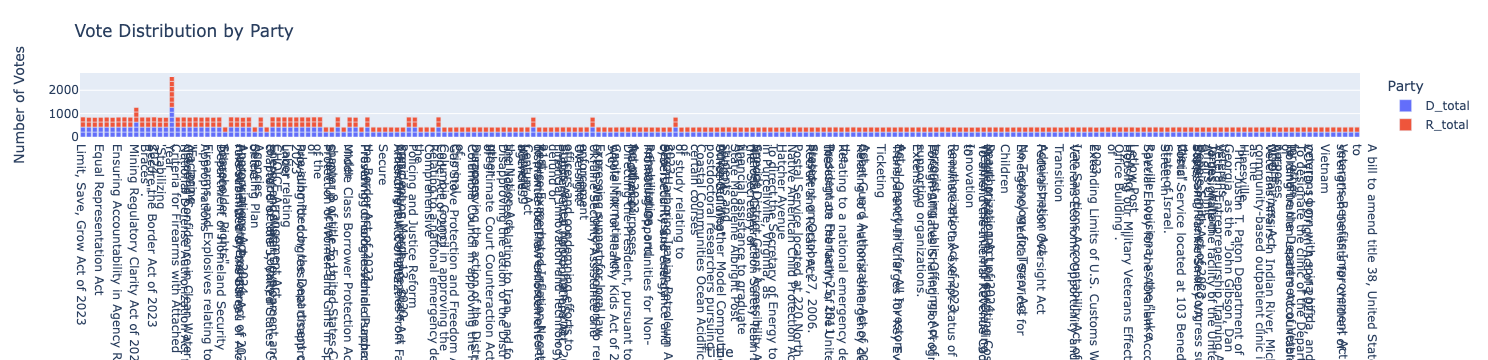

In [268]:
df['D_total'] = df['D_yea_or_aye_votes'] + df['D_nay_or_no_votes'] + df['D_abstain_votes']
df['R_total'] = df['R_yea_or_aye_votes'] + df['R_nay_or_no_votes'] + df['R_abstain_votes']
df['I_total'] = df['I_yea_or_aye_votes'] + df['I_nay_or_no_votes'] + df['I_abstain_votes']

fig = px.bar(df, x='title', y=['D_total', 'R_total', 'I_total'], 
             labels={'value':'Number of Votes', 'variable':'Party'},
             title='Vote Distribution by Party')
fig.show()

In [276]:
# EXPERIMENT WITH DIFFERENT AXES
fig = px.scatter(df[df['closeness_rank'] <=25], 
                 x='policy_area', 
                 y='yea_nay_gap_votes', 
                 # size=df['abs_yea_nay_gap_vote'].astype(float),  # Convert to float for size
                 color='result',
                 hover_name='title',
                 hover_data={'result': True,
                             'yea_nay_gap_votes': True, 
                             'title': True,
                             'D_yea_or_aye_votes': True,
                             'R_yea_or_aye_votes': True,
                             'most_recent_text_short':True,
                            },
                 title='Subjects of Bills with Closest Votes')

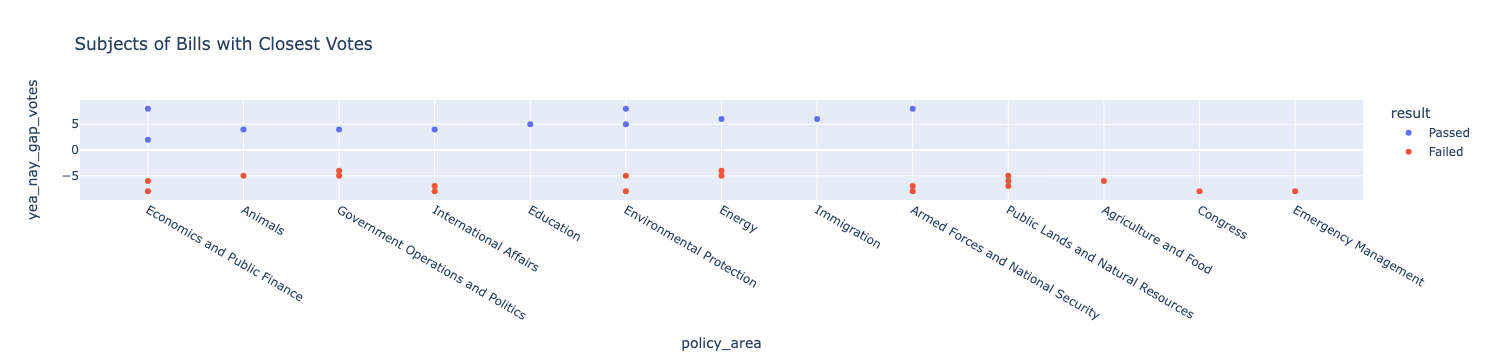

In [277]:
fig.show()

# Committees

In [290]:
sql = """
with cte as(
SELECT dv.bill_type
      ,dv.chamber
      ,dv.roll_call_number
      ,dv.result
      ,db.bill_name
      ,db.title
      ,bridge.name committee_name
    FROM `Congress.dim_votes` dv
        join `Congress.dim_bills` db on (dv.bill_key = db.bill_key)
        left join `Congress.bill_committee_bridge` bridge on db.bill_key = bridge.bill_key
    WHERE dv.chamber = 'House'
        )

select committee_name, sum(case 
                          when result = 'Passed' then 1
                          else 0 end) as number_passed,
                       sum(case 
                          when result = 'Failed' then 1
                          else 0 end) as number_failed,
                       count(*) as number_sponsored
from cte
group by committee_name
order by number_passed desc


"""


In [291]:
df = pandas_gbq.read_gbq(sql, project_id=project_id)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [292]:
df.head()

,committee_name,number_passed,number_failed,number_sponsored
0,Judiciary Committee,56,8,64
1,Energy and Commerce Committee,37,10,47
2,Financial Services Committee,35,3,38
3,Foreign Affairs Committee,32,11,43
4,Veterans' Affairs Committee,29,2,31


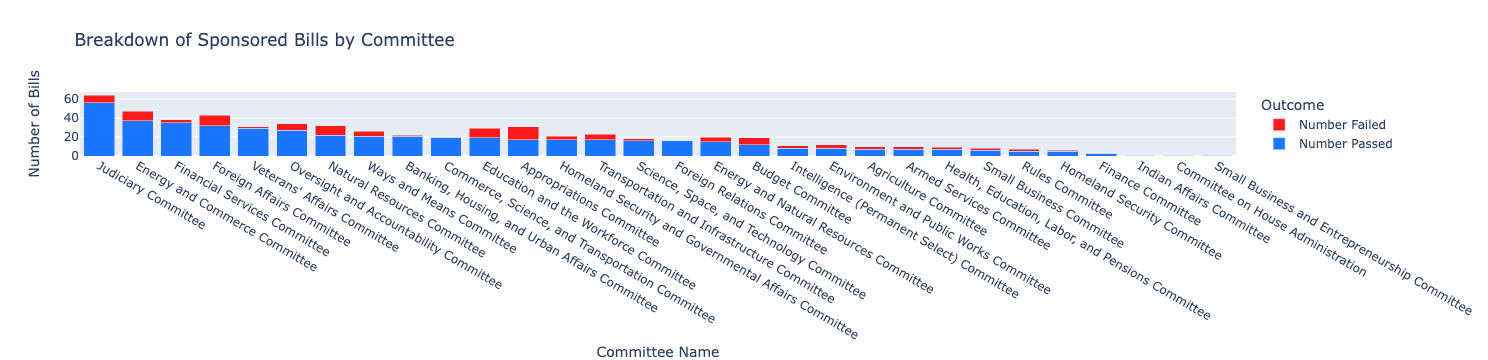

In [297]:
# ADD RECENT BILLS PASSED

# Convert data to columns
committee_names = df['committee_name']
number_passed = df['number_passed']
number_failed = df['number_failed']

# Create the stacked bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=committee_names,
    y=number_passed,
    name='Number Passed',
    marker_color='rgb(26, 118, 255)'
))

fig.add_trace(go.Bar(
    x=committee_names,
    y=number_failed,
    name='Number Failed',
    marker_color='rgb(255, 26, 26)'
))

# Update the layout
fig.update_layout(
    barmode='stack',
    title='Breakdown of Sponsored Bills by Committee',
    xaxis=dict(title='Committee Name'),
    yaxis=dict(title='Number of Bills'),
    legend=dict(title='Outcome')
)

# Display the figure
fig.show()